# Blocks

> Building blocks for DL models

## Setup

In [ ]:
#| default_exp blocks

In [ ]:
#| export
import math, torch, torch.nn as nn,fastcore.all as fc
from einops import rearrange
from models.core import *
from fastcore.all import partial

## Key functions

In [ ]:
#| export
def make_model(block_type, units, **kwargs):
    "Build models based on block and units"
    layers = nn.Sequential()
    for i in range(len(units)-1):
        # Use the block_type parameter to dynamically create blocks
        block = block_type(units[i], units[i+1], **kwargs)
        layers.append(block)
    return layers

## Linear
> (bs, features)

In [ ]:
#| export
def lin(ni, nf, act=nn.SiLU, norm=None,bias=True,dp=None):
    "single linear block"
    layers = nn.Sequential(nn.Linear(ni, nf, bias=bias))
    if norm: layers.append(norm(nf))
    if dp: layers.append(nn.Dropout(dp))
    if act : layers.append(act())
    return layers

In [ ]:
m = nn.Sequential(nn.BatchNorm1d(1),
                  lin(1,10,norm=nn.BatchNorm1d),
                  lin(10,20,dp=0.1),
                 lin(20,3,act=None))
m

Sequential(
  (0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): SiLU()
  )
  (3): Sequential(
    (0): Linear(in_features=20, out_features=3, bias=True)
  )
)

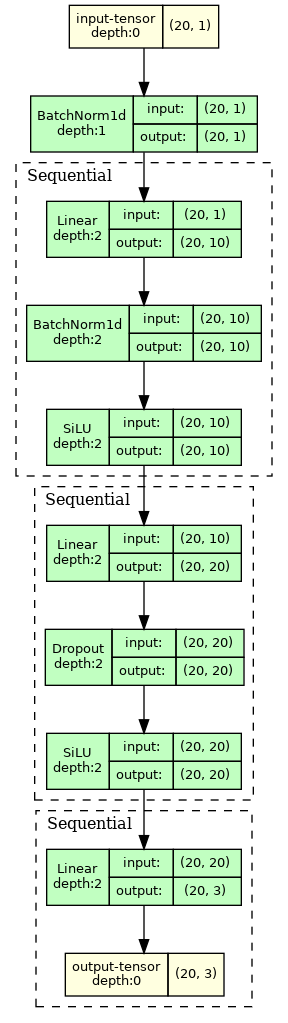

In [ ]:
plot_model(m,(20,1))

In [ ]:
# use partial
m = make_model(partial(lin,norm=nn.BatchNorm1d),[10,20,30])

In [ ]:
# or 
m = make_model(lin,[10,20,30],norm=nn.BatchNorm1d)

In [ ]:
m = m.append(nn.Linear(30,3))
m

Sequential(
  (0): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
  )
  (1): Sequential(
    (0): Linear(in_features=20, out_features=30, bias=True)
    (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
  )
  (2): Linear(in_features=30, out_features=3, bias=True)
)

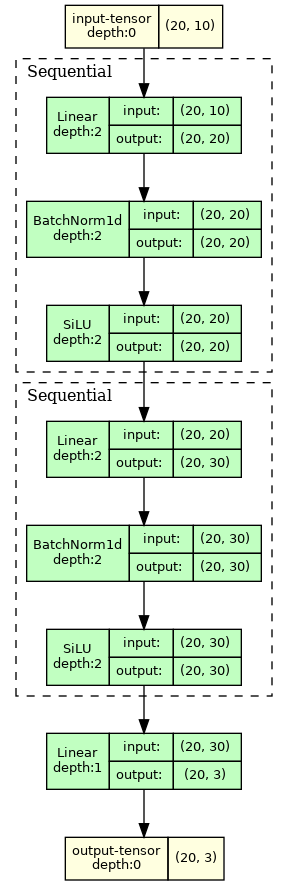

In [ ]:
plot_model(m,(20,10))

## Sequence with embeddings
> (bs, seq_length, embedding_dim)

### Transformer

[fastai part2, course 28 diffusion-attn-cond](https://github.com/fastai/course22p2/blob/df9323235bc395b5c2f58a3d08b83761947b9b93/nbs/28_diffusion-attn-cond.ipynb)

In [ ]:
#| export
class SelfAttn(nn.Module):
    
    def __init__(self, embedding_dim, nheads):
        super().__init__()

        self.nheads = nheads
        self.attn_chans = embedding_dim//self.nheads
        assert embedding_dim == self.attn_chans*self.nheads, "embedding_dim is not divisible by nheads"

        self.scale = math.sqrt(embedding_dim/self.nheads)
        self.norm = nn.LayerNorm(embedding_dim)
        self.qkv = nn.Linear(embedding_dim, embedding_dim*3)
        self.proj = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, x, mask=None):
        # bs,seq_length,embedding_dim
        b,l,h = x.shape

        x = self.norm(x)
        x = self.qkv(x)
        x = rearrange(x, 'b l (h attn_chans) -> b h l attn_chans', h=self.nheads)

        q,k,v = torch.chunk(x, 3, dim=-1)
        attn = (q@k.transpose(-1,-2))/self.scale
        attn = attn.softmax(dim=-1)

        if mask is not None:
            attn = attn*mask[:,None,None,:]

        x = attn@v
        x = rearrange(x, 'b h l attn_chans -> b l (h attn_chans)', h=self.nheads)
        x = self.proj(x)
        return x

In [ ]:
embedding_dim = 100
nheads=5
bs = 10
seq_len = 200

In [ ]:
#| output: false
m = SelfAttn(embedding_dim,nheads)

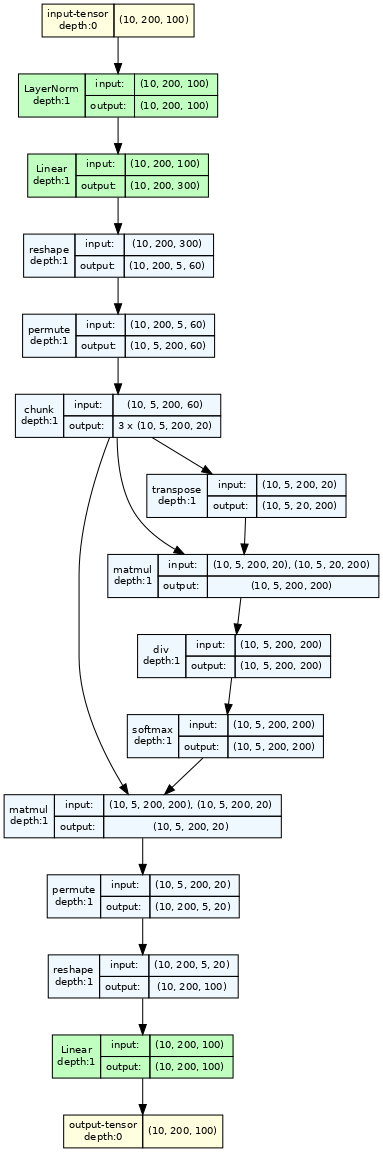

In [ ]:
plot_model(m,(bs,seq_len,embedding_dim),depth=1)

### Mamba

[Mamba](https://github.com/state-spaces/mamba)

This model is only available in cuda

In [ ]:
# !pip install causal-conv1d>=1.1.0 mamba-ssm

In [ ]:
# from mamba_ssm import Mamba

In [ ]:
# m = Mamba(d_model=198, d_state=16, d_conv=4,expand=2)

In [ ]:
# x = torch.randn(3, 200, 198).to('cuda')
# m = m.to('cuda')
# m(x)

In [ ]:
# plot_model(m,(3,200,198),device='cuda',depth=10)

## Images
> (bs, channels, height, width)

[Squeeze & Excitation](https://github.com/moskomule/senet.pytorch/blob/master/senet/se_module.py#L4)

In [ ]:
#| export
class SE(nn.Module):
    "Squeeze & Excitation block for image"
    def __init__(self, channel_in, reduction=2):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channel_in, channel_in // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel_in // reduction, channel_in, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.squeeze(x).squeeze()
        y = self.excitation(y)[:,:,None,None]
        return x * y.expand_as(x)

In [ ]:
channel_in = 6
reduction =2
bs = 10
seq_length = 200

In [ ]:
#| output: False
m = SE(channel_in,reduction)

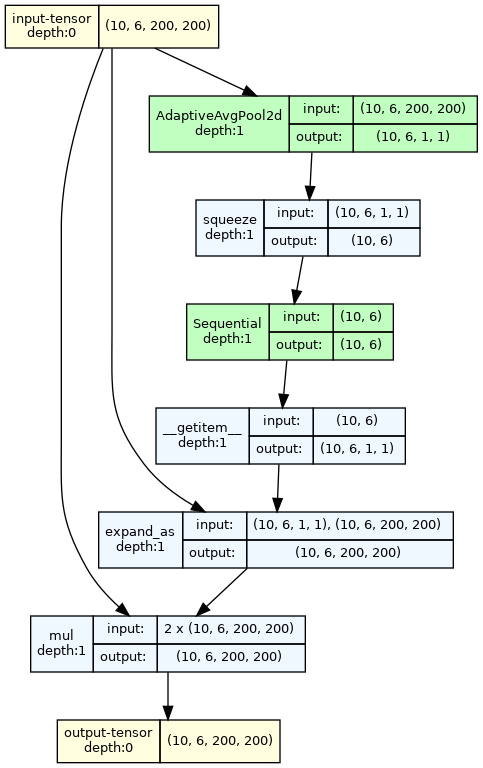

In [ ]:
plot_model(SE(channel_in,reduction),(bs,channel_in,seq_length,seq_length),depth=1)

[ResConv2dSimple](https://github.com/autosome-ru/vigg_ribonanza/blob/main/python_scripts/train_uni_adjnet.py)

In [ ]:
#| export
class Res_SE(nn.Module):
    "Resnet + SE block"
    def __init__(self, in_c, out_c,kernel_size=7):
        super().__init__()

        if not kernel_size % 2:
            raise ValueError("kernel_size should be an odd number")

        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size, padding='same', bias=False),
            nn.BatchNorm2d(out_c),
            SE(out_c),
            nn.GELU())

        self.res = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_c)) if in_c != out_c else fc.noop


    def forward(self, x):
        x = self.res(x) + self.conv(x)
        return x

In [ ]:
m = make_model(Res_SE,[1,5,10,20])

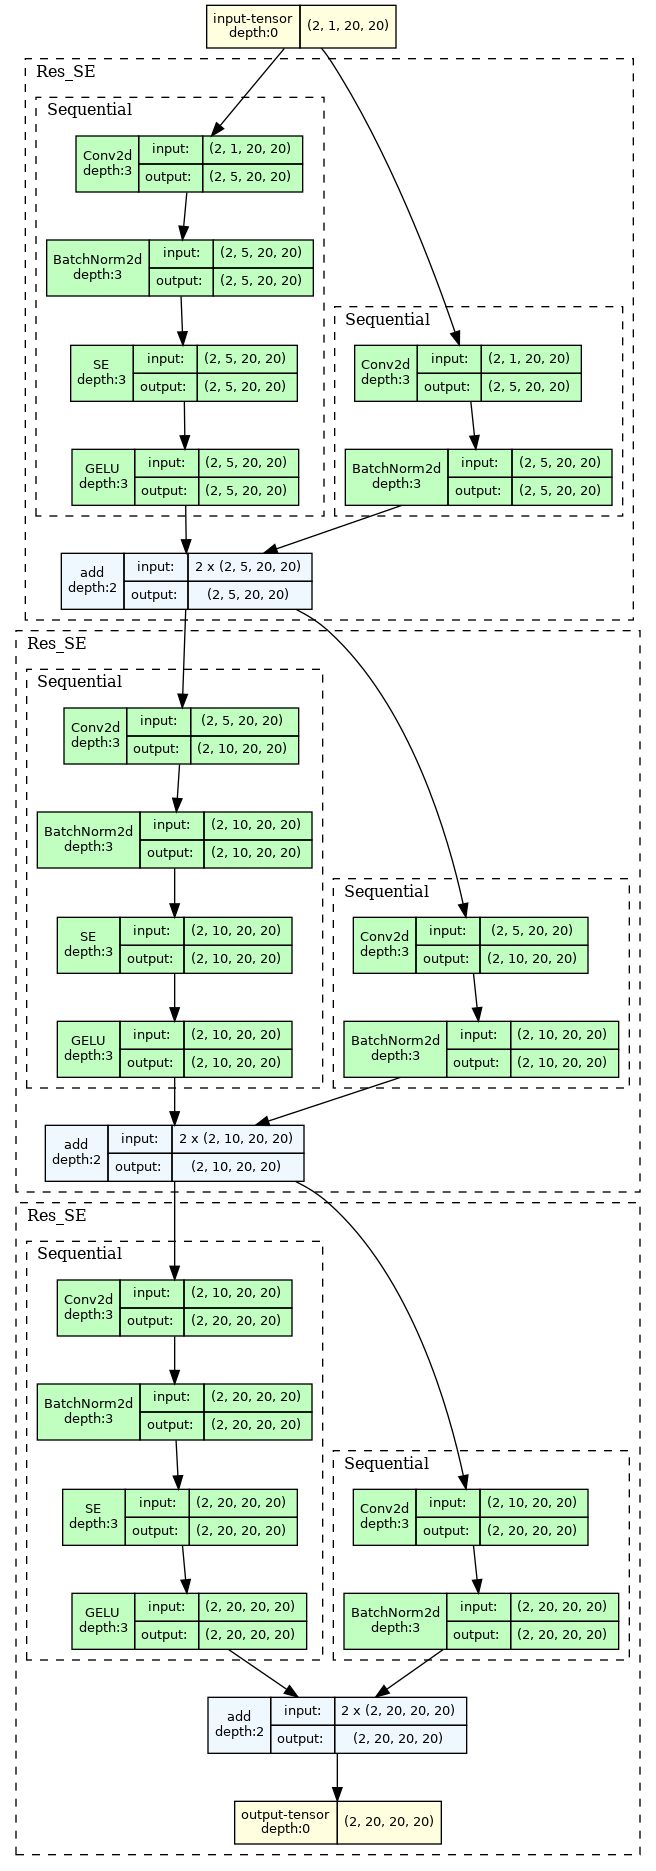

In [ ]:
plot_model(m,(2,1,20,20))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()